# Agent based or Individual based stochastic models  

## model conceptualization

* This is a model for describing Q fever transmission within a dairy herd. 
* The idea of the model is simple
* the probability of a susceptible cow to get infected depends on the environmental bacterial load in the herd
* an infected cow sheds bacteria in environment through various routes

https://royalsocietypublishing.org/doi/full/10.1098/rspb.2010.0575

![alt text](rspb20100575-g1.jpg "Title")

We are developing a simpler version of the model.  
We will assume SIR transmission 

## importing packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import math as math
import random as random 
from scipy import stats as stats
import math as ma
import scipy.special as sp
import pandas as pd
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_context("notebook", font_scale=1.30, rc={"lines.linewidth": 0.8})
%matplotlib inline

C:\Users\falco\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\falco\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\falco\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Lets understand stochasticity

* Stochastic processes are randomly determined processes.   
* They are random but still have some central tendency.

### coin toss

In [2]:
probability = 0.5

In [3]:
np.random.multinomial(1, [probability, 1-probability])

array([1, 0])

In [4]:
def toss_coin():
    result = np.random.multinomial(1, [probability, 1-probability])
    if result[0] == 1:
        print('Heads')
    elif result[1] == 1:
        print('Tails')

In [5]:
toss_coin()

Tails


### multiple outcomes

![alt text](probability.jpg "Title")

* at time *t*
* probability of an individual to get infected with normal shedding is 0.4
* and to become a super spreader is 0.1
* hence for it to remain susceptible is 1-(0.1+0.4) = 0.5

In [6]:
p_infection = 0.4 ## probability to get infected
p_superspreader = 0.1 ## probability to become super spreader

def change_susceptibles():
    result = np.random.multinomial(1, [(1-(p_infection+ p_superspreader)), p_infection, p_superspreader])
    if result[0] == 1:
        print('remain susceptible')
    elif result[1] == 1:
        print('become infected')
    elif result[2] == 1:
        print('become super-spreader')

In [7]:
np.random.multinomial(1, [(1-(p_infection+ p_superspreader)), p_infection, p_superspreader])

array([0, 1, 0])

In [8]:
change_susceptibles()

become infected


In [9]:
for i in range(100):
    change_susceptibles()

become infected
become infected
remain susceptible
remain susceptible
remain susceptible
become infected
remain susceptible
remain susceptible
become infected
remain susceptible
remain susceptible
remain susceptible
become infected
remain susceptible
become infected
become super-spreader
become super-spreader
remain susceptible
remain susceptible
become infected
remain susceptible
become infected
become infected
become infected
remain susceptible
remain susceptible
become infected
remain susceptible
become super-spreader
remain susceptible
become infected
remain susceptible
become infected
become super-spreader
become infected
become super-spreader
become infected
remain susceptible
become infected
become infected
become infected
become infected
become infected
become infected
become infected
become super-spreader
become infected
become infected
become infected
become infected
remain susceptible
remain susceptible
become infected
remain susceptible
remain susceptible
remain susceptible

## Object oriented modeling

In [15]:
n = 20
class Person:
    name = ""
    workplace = ""
    age  = n
    def __init__(self, personName, workplace, n):
        self.name = personName
        self.workplace = workplace
        self.age = n

    def __repr__(self):
        return str(self.name)+', '+str(self.workplace)

In [16]:
Pranav = Person('Pranav', "UC Davis")

TypeError: __init__() missing 1 required positional argument: 'n'

In [17]:
Pranav

NameError: name 'Pranav' is not defined

## Model Parameters

In [18]:
pi= ma.pi

##Transmission probabilities 
m = 0.7; ##Transition probability from I- to S
q = 0.02; ##Transition Probability from I- to I+
pIp = 0.5; ## Proportion of Cows going from I- to I + and becoming I+ milk pers
r1 = 0.2; ##Transition Probability I= to C=
r2 = 0.02; ## Transition Probability I+ to C+
s = 0.15; ##Transition Probability C+ to I+
tau = 0.0096; ##Transition probability C+ to C-
pc = 1; ##Transition Probability from C- to I+

mu = 0.2 ## DEATH OF BACTERIA IN ENVIRONMENT COMPARTMENT
pmf = 0.28; ##Probability of bacteria shed hrough muucs/ feces filing the environement compartment 

## Shedding level probabilities for Iminus 
qte1 = [0.85,0.15,0];
rho = 0.28; ##fraction of excreted bacteria in mucus / feces contaminating the environment
High = 1/float(30); ##qunatity of bacteria shed by high shedding animal durin one week
#High = 1
intitialheardsize = 50; #Animals in the herd

## Agent characteristics 

In [19]:
def enum(enumName, *listValueNames):
    # A sequence of integers, we create as 
    # As there are values in the enum.
    listValueNumbers = range(len(listValueNames))
    # Creation definately attributes. 
    # Fill with initial correspondence: enum value -> integer
    dictAttrib = dict( zip(listValueNames, listValueNumbers) )
    # Create the reverse dictionary. whole -> enum value
    dictReverse = dict( zip(listValueNumbers, listValueNames) )
    # Adding the inverse dictionary in attributes
    dictAttrib["dictReverse"] = dictReverse
    # Create and renvoyage type
    mainType = type(enumName, (), dictAttrib)
    return mainType
    
Health = enum("Health", "Susceptible", "Infected", "Recovered")
Herdinfectedornot = enum("Herdinfectedornot","InfectionFree", "Infected")
HerdExposedtoBacteria = enum("HerdExposedtoBacteria","NotExposed","Exposed")

## Agents

In [20]:
class Cow(object):
    def __init__(self, healthstate = Health.Susceptible):
        self.healthstate = healthstate
        
    def __repr__(self):
        return str(self.healthstate)
    
    def setHealthState(self, state):
        self.healthstate = state
    
    def changeSusceptible(self, Multinomial):
        if Multinomial[1] == 1:
            self.healthstate = Health.Infected
            return True
        return False
    
    def changeInfected(self, Multinomial):
        if Multinomial[0] == 1:
            self.setHealthState(Health.Susceptible)
            return True
        elif Multinomial[1] == 1:
            self.setHealthState(Health.Infected)
        elif Multinomial[2] ==1:
            self.setHealthState(Health.Recovered)
            return True
        return False

In [21]:
class calendar (object):
    def __init__(self, week=random.randint(1,52)):
        self.week = week
       
    def ChangeOneWeek (self):
        if self.week < 52:
            self.week = self.week+1;
        if self.week == 52:
            self.week = 0

In [22]:
####################################################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

########################                                       Description of Objects:  Herd

            
class Herd (object):
    def __init__(self, initialHerdSize=None, time = None, HerdId = None):
        self.initialHerdSize = initialHerdSize
        self.time = time
        self.HerdID = HerdId
        self.A = 17*self.initialHerdSize
        
        self.S = 0;
        self.I = 0;
        self.R = 0;
        self.E = 0;
        
        self.Slist = []
        self.Ilist = []
        self.clist = []
        self.Elist = []
        self.Elist.append(self.E)
        self.Nlist = []
        self.incidence = np.zeros(time_length)
        
        self.N = initialHerdSize
        
        
        
        self.pinfection = 1-math.exp(-(self.E))
        
        self.Herdinfectionstate = False 
        
        
        self.PopulateHerd()
        
    def PopulateHerd(self):
        self.lCows = [Cow(healthstate=Health.Susceptible) for i in range(self.initialHerdSize)]
        
    def __repr__(self):
        return str(self.HerdID)
    def InitiateInfection(self,TimeStep):
        #self.lCows[0].healthstate = Health.Infected;
        #self.lCows[1].healthstate = Health.Infected;
        
        #self.Herdinfectionstate = True
        self.HerdExposedAir = HerdExposedtoBacteria.Exposed
        self.E = 0.01
#        self.indexcases = 4

    def InfectionDynamics (self, TimeStep):
        if self.pinfection<0:
            self.pinfection =0
        ## loop for all cows
        for iCow in self.lCows:
            if iCow.healthstate==Health.Susceptible: 
                state=np.random.multinomial(1, [(1-self.pinfection), self.pinfection])
                isInfected = iCow.changeSusceptible(state)
                #if isInfected:
                #    print(iCow.healthstate)


            elif iCow.healthstate==Health.Infected:
                state=np.random.multinomial(1,[m,(1-m-q),q])
                becomingSusceptible = iCow.changeInfected(state)
                    
        ## Live animals, will be counted each time step
        self.S=0;
        self.I=0;
        self.c=0;
        self.N=0; 
        
#____________Enumerating number of animals in each healthstate _______________________________________________________________________________________________________________________________________________________________
        
        for iCow in (self.lCows[:]):
            if iCow.healthstate==Health.Susceptible:
                self.S+=1
            elif iCow.healthstate==Health.Infected:
                self.I+=1
            elif iCow.healthstate==Health.Recovered:
                self.c+=1
        self.N  =self.S+self.I +self.c
        #print(self.I)
        
        
    def BacteriaExcretion (self):
        E1=0;
        Q1Dl = 0;
        ## Calculating the bacteria shedd at time "t"
        for iCow in self.lCows:
            if iCow.healthstate==Health.Infected:# I shedding with feces
                sheddinglevelprob=np.random.multinomial(1,qte1)
                if sheddinglevelprob[1]==1:
                    Q1Dl+=1 ## *low
        
#____________Counting the Bacteria shed accordint to the SEASON _______________________________________________________________________________________________________________________________________________________________        
        E1=Q1Dl*High*rho
        self.E+=(E1-(self.E*mu))
        #print(self.E)
        
    
    def calculationInfectionProbability (self):
        self.pinfection=1-math.exp(-(self.E))
        #print(self.pinfection)
        
    
    def appendingTimeLoopResults(self):
        self.Slist.append(self.S)
        self.Ilist.append(self.I)
        self.clist.append(self.c)
        self.Nlist.append(self.N)
        self.Elist.append(self.E)
        
        if self.Herdinfectionstate == True and self.I == 0:
            self.Herdinfectionstate == False
            

In [23]:
class ResultsInfectionCause (object):
    def __init__ (self,lHerds):
        self.Prevalence=0
    def appendInfectionCauses (self, lHerds):
        for iHerd in lHerds:
            #if iHerd.Herdinfectionstate:
            if iHerd.ExposedBy != infectionCause.Free :
                self.Prevalence+=1    
            
class Results (object):
    def __init__(self):
        self.Susc = []  ##Suscpetibles
        self.INFECTED= [] ##Iminus milk shedders
        self.CARRIERS = [] ##Carriers
        self.Eload=[] ## Environmental bacterial load
        
    def appendingSimuLoopResults (self, iHerd):
        self.Susc.append(iHerd.Slist)  ##Suscpetibles
        self.INFECTED.append(iHerd.Ilist) 
        self.CARRIERS.append(iHerd.clist) ##Carriers
        self.Eload.append(iHerd.Elist) ## Environmental bacterial load
        
class SavingResultsInfectionCause (object):
    def __init__(self):
        self.HerdPrevalence=[]
    
    def appendingresultsofinfectioncause (self, HerdPrevalence):
        self.HerdPrevalence.append(HerdPrevalence)

class HerdInfectionProbability (object):
    def __init__ (self, simu):
        self.InfectedTimes= [0 for x in range(Herds)]
        self.ExposedByWIND= [0 for x in range(Herds)]
        self.ExposedByMOVEMENT= [0 for x in range(Herds)]
        self.MeanTimeforINFECTION=[[0 for x in range (simu)] for h in range(Herds)]
        
    def HerdInfectionProb (self,lHerds,si):
        for iHerd in lHerds:
            if iHerd.Herdinfectionstate== True:
                self.InfectedTimes[lHerds.index (iHerd)] +=1
            if iHerd.ExposedBy == infectionCause.Wind :
                self.ExposedByWIND[lHerds.index (iHerd)] +=1
            if iHerd.ExposedBy == infectionCause.Movement :
                self.ExposedByMOVEMENT[lHerds.index (iHerd) ]+=1
            if iHerd.TimeforInfection!= None:
                self.MeanTimeforINFECTION[lHerds.index (iHerd)][si]= iHerd.TimeforInfection

## Simulation

In [24]:
lResults = Results()

### Running simulation

In [25]:
%%time
### this command just print out the computer time required ro run this command

years=5; 
time_length=52*years;  ## number of time steps I am running the model
dt=1;  #time step
simu=100; #number of stochastic iteration

#### loop function that will run the model n times (n being the number of stochastic iterations)

for s in range(simu):
    ### generate a herd
    iHerd = Herd(
        initialHerdSize=100,
        HerdId="UCDavis",
    )
    ## create cows in our herd
    iHerd.PopulateHerd()
    ##inisitate infection 
    iHerd.InitiateInfection(TimeStep=1)
    
    ## Start the time loop
    for t in range (time_length):

        iHerd.InfectionDynamics(TimeStep=t) ## first infection dynamics will play, cows will change their health states
        iHerd.BacteriaExcretion() ## then infected cows will shed bacteria in the environment
        iHerd.calculationInfectionProbability() ## estimate the probability of infection for a new cow based on the contamination
        iHerd.appendingTimeLoopResults() ## save results in for time t
        
    ## save results of one stochastic iteration in Results object
    lResults.appendingSimuLoopResults(iHerd)

Wall time: 37.3 s


## Plotting results

In [26]:
## Convert all results to dataframe for easy plotting
Susceptibles = pd.DataFrame(lResults.Susc).T
Infected = pd.DataFrame(lResults.INFECTED).T
Recovered = pd.DataFrame(lResults.CARRIERS).T
Eload = pd.DataFrame(lResults.Eload).T

### Plot for health states

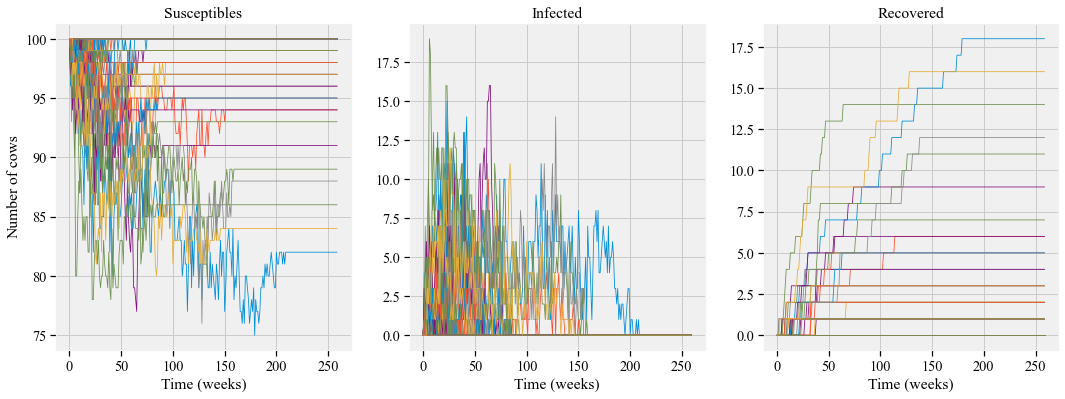

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = False, figsize  = [16,6])
#Susceptibles.plot(color = '#808080', ax = ax1)
#Infected.plot(color = '#808080', ax = ax2)
#Recovered.plot(color = '#808080', ax = ax3)
Susceptibles.plot( ax = ax1)
Infected.plot( ax = ax2)
Recovered.plot( ax = ax3)
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax1.set_xlabel('Time (weeks)')
ax2.set_xlabel('Time (weeks)')
ax3.set_xlabel('Time (weeks)')
ax1.set_ylabel('Number of cows')
ax1.set_title('Susceptibles')
ax2.set_title('Infected')
ax3.set_title('Recovered')

plt.show()

### plot for environmental contamination 

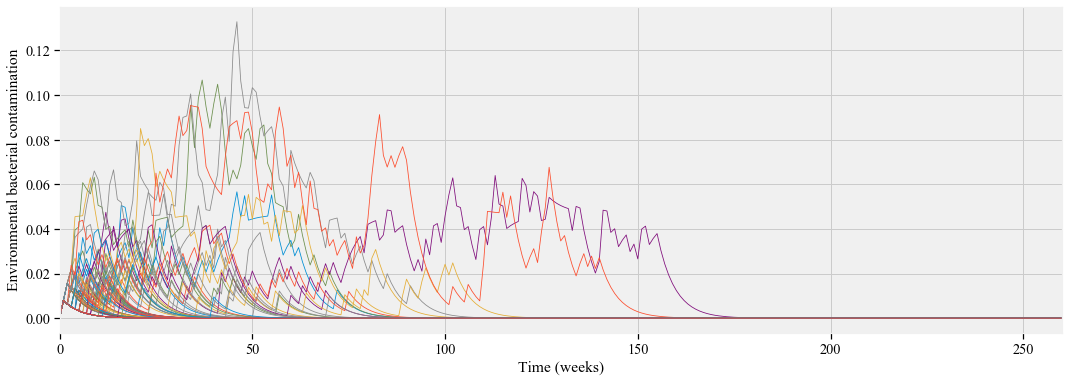

In [45]:
fig, (ax1) = plt.subplots(1, 1, sharey = True, figsize  = [16,6])
#Eload.plot(color = '#808080', ax = ax1)
Eload.plot(ax = ax1)
ax1.get_legend().remove()
ax1.set_xlabel('Time (weeks)')
ax1.set_ylabel('Environmental bacterial contamination')
plt.show()

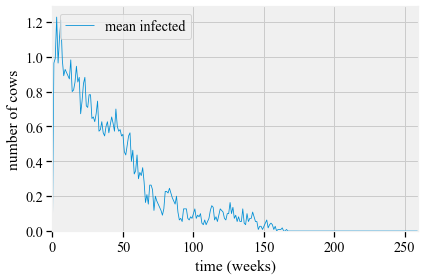

In [46]:
fig, ax = plt.subplots(figsize = (6,4))
Infected.mean(axis=1).plot(ax= ax,label='mean infected')
ax.set_ylim(0)
plt.legend(loc='upper left')
ax.set_ylabel('number of cows')
ax.set_xlabel('time (weeks)')
plt.tight_layout()
plt.show()

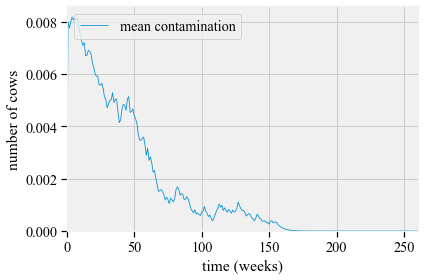

In [47]:
fig, ax = plt.subplots(figsize = (6,4))
Eload.mean(axis=1).plot(ax= ax,label='mean contamination')
ax.set_ylim(0)
plt.legend(loc='upper left')
ax.set_ylabel('number of cows')
ax.set_xlabel('time (weeks)')
plt.tight_layout()
plt.show()

## Making it mode complicated and complex to represent real life heterogeneities 

https://veterinaryresearch.biomedcentral.com/articles/10.1186/s13567-016-0330-4

![alt text](13567_2016_330_Fig2_HTML.webp "Title")

![alt text](13567_2016_330_Fig1_HTML.webp "Title")